<a href="https://colab.research.google.com/github/SofiaRguez1020/Topicos_Industria_I/blob/main/TI_1_Practica4_Sofia_Rodriguez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 4

**Nombre:** Sofia Daniela Rodriguez Saenz

**e-mail:** sofia.rodriguez5540@alumnos.udg.mx

# MODULES

In [1]:
import math
import numpy as np
import pandas as pd

import plotly.graph_objects as go

from scipy.stats import wrapcauchy
from scipy.stats import cauchy
from scipy.stats import levy_stable

import panel as pn
import panel.widgets as pnw

pn.extension('plotly')

# CLASSES

In [5]:
################# http://www.pygame.org/wiki/2DVectorClass ##################
class Vec2d(object):
    """2d vector class, supports vector and scalar operators,
       and also provides a bunch of high level functions
       """
    __slots__ = ['x', 'y']

    def __init__(self, x_or_pair, y = None):
        if y == None:
            self.x = x_or_pair[0]
            self.y = x_or_pair[1]
        else:
            self.x = x_or_pair
            self.y = y

    # Addition
    def __add__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x + other.x, self.y + other.y)
        elif hasattr(other, "__getitem__"):
            return Vec2d(self.x + other[0], self.y + other[1])
        else:
            return Vec2d(self.x + other, self.y + other)

    # Subtraction
    def __sub__(self, other):
        if isinstance(other, Vec2d):
            return Vec2d(self.x - other.x, self.y - other.y)
        elif (hasattr(other, "__getitem__")):
            return Vec2d(self.x - other[0], self.y - other[1])
        else:
            return Vec2d(self.x - other, self.y - other)

    # Vector length
    def get_length(self):
        return math.sqrt(self.x**2 + self.y**2)

    # rotate vector
    def rotated(self, angle):
        cos = math.cos(angle)
        sin = math.sin(angle)
        x = self.x*cos - self.y*sin
        y = self.x*sin + self.y*cos
        return Vec2d(x, y)

# FUNCTIONS

In [8]:
###############################################################################################
# Brownian Motion
# This function generates a BM walk
###############################################################################################
def bm_2d(n_steps=1000, speed=5, s_pos=[0,0]):
  """
  Arguments:
    n_steps: number of steps the Brownian Trajectory will take -> int
    speed: speed of the trajectory or step size -> int
    s_pos: initial position -> [x,y] list
  Returns:
    BM_2d_df: DataFrame with x,y points of the full trajectory
  """

  # Init velocity vector
  velocity = Vec2d(speed, 0)

  BM_2d_df = pd.DataFrame(columns = ['x_pos', 'y_pos'])
  temp_df = pd.DataFrame([{'x_pos': s_pos[0], 'y_pos': s_pos[1]}])

  BM_2d_df = pd.concat([BM_2d_df, temp_df], ignore_index=True)

  for i in range(n_steps-1):
    turn_angle = np.random.uniform(low=-np.pi, high=np.pi)
    velocity = velocity.rotated(turn_angle)

    temp_df = pd.DataFrame([{'x_pos': BM_2d_df.x_pos[i]+velocity.x, 'y_pos': BM_2d_df.y_pos[i]+velocity.y}])

    BM_2d_df = pd.concat([BM_2d_df, temp_df], ignore_index=True)

  return BM_2d_df

In [6]:
###############################################################################################
# Correlated Random Walk
# This function generates a CRW Walk
###############################################################################################
def crw(n_steps=1000, speed=5, s_pos=[0,0], CRW_exponent = 0.5):
  """
  Arguments:
    n_steps: number of steps the Brownian Trajectory will take -> int
    speed: speed of the trajectory or step size -> int
    s_pos: initial position -> [x,y] list
  Returns:
    CRW_df: DataFrame with x,y points of the full trajectory
  """
  #Init DFs
  CRW_df = pd.DataFrame(columns=['x_pos', 'y_pos'])
  temp_df = pd.DataFrame([{'x_pos': s_pos[0], 'y_pos': s_pos[1]}])
  CRW_df = pd.concat([CRW_df, temp_df], ignore_index=True)

  # Init velocity vector
  velocity = Vec2d(speed,0)

  for i in range(n_steps-1):
    # Select turn angle
    turn_angle = wrapcauchy.rvs(c=CRW_exponent)
    #
    velocity = velocity.rotated(turn_angle)
    #Update position
    temp_df = pd.DataFrame([{'x_pos': CRW_df.x_pos[i]+velocity.x, 'y_pos': CRW_df.y_pos[i]+velocity.y}])
    CRW_df = pd.concat ([CRW_df,temp_df], ignore_index=True)
  return CRW_df

In [ ]:
###############################################################################################
# Levy flight
# This function generates a levy flight
###############################################################################################
def levy_flight(n_steps=1000, init_speed = 5, s_pos=[0,0], CRW_exponent = 0.5, alpha = 1.5, beta = 0, loc=3.0):
  #Init DFs
  Levy_df = pd.DataFrame(columns=['x_pos', 'y_pos'])
  temp_df = pd.DataFrame([{'x_pos': s_pos[0], 'y_pos': s_pos[1]}])
  Levy_df = pd.concat([Levy_df, temp_df], ignore_index=True)

  # Init velocity vector
  velocity = Vec2d(init_speed,0)

  for i in range(n_steps-1):
    # Select turn angle
    turn_angle = wrapcauchy.rvs(c=CRW_exponent)
    #step size
    step_size = levy_stable.rvs(alpha=alpha, beta=beta, loc=loc)

    velocity = velocity.rotated(turn_angle)
    #Update position
    temp_df = pd.DataFrame([{'x_pos': Levy_df.x_pos[i]+(velocity.x*step_size), 'y_pos': Levy_df.y_pos[i]+(velocity.y*step_size)}])
    Levy_df = pd.concat ([Levy_df,temp_df], ignore_index=True)
  return Levy_df

In [ ]:
#######################################################################################################
# Euclidean distance
# This function estimates euclidean distance between two points
#######################################################################################################
def euclidean_distance(q, p):
  a2 = (q[0] - p[0])**2
  b2 = (q[1] - p[1])**2
  c = math.sqrt(a2+b2)
  return c

#######################################################################################################
# Path length calculation
# This function estimates the total path length based on euclidean distance between consecutive steps
#######################################################################################################
def path_length(trajectory):
  """
  Arguments:
    trajectory: Data set containing complete trajectory
  Returns:
    distance: calculated euclidean distance between 2 points
  """
  dis_aux = []
  for i in range (1,trajectory.shape[0]):
    dis_aux.append(euclidean_distance(trajectory.iloc[i-1], trajectory.iloc[i]))
  return pd.DataFrame(np.cumsum(dis_aux), columns=['PL'])

In [ ]:
#######################################################################################################
# Mean Squared Displacement
# This function estimates the MSD
#######################################################################################################
def msd(trajectory, n=50):
  """
  Arguments:
    trajectory: Data set containing complete trajectory
    n: Window size
  Returns:
    msd_df: calculated mean squared
  """
  displacement_vec = np.array([euclidean_distance(trajectory.iloc[i-n], trajectory.iloc[i])**2 for i in range(n, trajectory.shape[0],1)])
  msd_df = pd.DataFrame(np.cumsum(displacement_vec)/(trajectory.shape[0] - n), columns=['MSD'])
  return msd_df

#Dashboard implementation

RadioButtonGroup(name='Panel', options=['BM', 'CRW', 'LF'], value='BM')

In [49]:
pn.extension()

trajectory_type = pn.widgets.ToggleGroup(name='Panel', options=['BM', 'CRW', 'LF'], behavior="radio", width = 320, align='center')
n_steps = pn.widgets.IntSlider(name='Number of steps:', start=10, end=1000, value=500, width = 320, align = 'center')
x_pos = pn.widgets.IntInput(name='xInitPos', value=0, width = 150)
y_pos = pn.widgets.IntInput(name='yInitPos', value=0, width = 150)
speed = pn.widgets.IntSlider(name='Speed', start=1, end=15, value=5, width = 320, align='center')

pn.Row(
    pn.WidgetBox(pn.pane.Markdown("# Panel options", align='center'),
                 trajectory_type,
                 n_steps,
                 pn.Row(x_pos, y_pos, align = 'center'),
                 speed,
                 width= 380,
                 height = 320)
)

Row
    [0] WidgetBox(height=320, sizing_mode='fixed', width=380)
        [0] Markdown(str, align='center')
        [1] RadioButtonGroup(align='center', name='Panel', options=['BM', 'CRW', 'LF'], value='BM', width=320)
        [2] IntSlider(align='center', end=1000, name='Number of steps:', start=10, value=500, width=320)
        [3] Row(align='center')
            [0] IntInput(name='xInitPos', width=150)
            [1] IntInput(name='yInitPos', width=150)
        [4] IntSlider(align='center', end=15, name='Speed', start=1, value=5, width=320)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
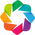

Launching server at http://localhost:43281


In [17]:
import panel as pn
import holoviews as hv
import numpy as np

# Activate the holoviews panel extension
hv.extension('bokeh')
pn.extension()

# Create dummy objects to represent the contents of the grid
# You'll replace these with your actual plots and widgets
trajectory_plot = hv.Scatter(np.random.randn(100, 2), vdims='z')
metrics_plot = hv.Curve(np.random.randn(100).cumsum(), label='MSD')

# Define your GridSpec layout
gspec = pn.GridSpec(sizing_mode='stretch_both')

# Add elements to the GridSpec
gspec[0:2, 0:6] = pn.Card(trajectory_plot, title='3D Trajectory')
gspec[0:2, 6:12] = pn.Card(metrics_plot, title='Metrics')
gspec[2:4, 0:3] = pn.WidgetBox('# Panel params', pn.widgets.RadioButtonGroup(name='Radio Button Group', options=['Option 1', 'Option 2', 'Option 3']), pn.widgets.FloatSlider(name='Float Slider'))
gspec[2:4, 3:6] = pn.WidgetBox('# Metrics type', pn.widgets.Select(name='Select', options=['Option 1', 'Option 2']))

# Show the GridSpec
gspec.show()
